Now, a 'subsurface' class sits in utils. This handles all the things that you need to do before defining a stimulus.

In [1]:
%load_ext autoreload
%autoreload 2
from prfpy.utils import subsurface

/tank/hedger/software/prfpy_NH/prfpy/model.py:3: UserWarning: 

 | Using Nistats with Nilearn versions >= 0.7.0 is redundant and potentially conflicting.
 | Nilearn versions 0.7.0 and up offer all the functionality of Nistats as well the latest features and fixes.
 | We strongly recommend uninstalling Nistats and using Nilearn's stats & reporting modules.

  from nistats.hemodynamic_models import spm_hrf, spm_time_derivative, spm_dispersion_derivative


In [2]:
import cortex
roi_verts = cortex.get_roi_verts('hcp_999999', 'V1',mask=True)

In [3]:
maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

In [4]:
myv1surf=subsurface('hcp_999999',[maskL,maskR])

In [5]:
myv1surf.create()

Generating subsurfaces
Creating distance by distance matrices


/tank/hedger/software/anaconda3/envs/p3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [6]:
myv1surf.distance_matrix

array([[0.        , 1.24027392, 2.88532564, ...,        inf,        inf,
               inf],
       [0.71221074, 0.        , 1.60887214, ...,        inf,        inf,
               inf],
       [2.25014134, 1.30320888, 0.        , ...,        inf,        inf,
               inf],
       ...,
       [       inf,        inf,        inf, ..., 0.        , 0.98343155,
        1.88453612],
       [       inf,        inf,        inf, ..., 1.06412855, 0.        ,
        0.75200825],
       [       inf,        inf,        inf, ..., 2.10753158, 1.09422208,
        0.        ]])

Now we create a matrix where distances to the other hemisphere are padded with np.Inf. This way, they are never included in the CF.

In [7]:
import nibabel as nib

datl1=nib.load('/tank/hedger/DATA/HCP_temp/late/tfMRI_MOVIE1_AP_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries_sg_psc_L.gii')
datr1=nib.load('/tank/hedger/DATA/HCP_temp/late/tfMRI_MOVIE1_AP_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries_sg_psc_L.gii')

datl2=nib.load('/tank/hedger/DATA/HCP_temp/late/tfMRI_MOVIE2_PA_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries_sg_psc_L.gii')
datr2=nib.load('/tank/hedger/DATA/HCP_temp/late/tfMRI_MOVIE2_PA_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries_sg_psc_L.gii')

import numpy as np
mydatl=np.array(datl1.agg_data()).T
mydatr=np.array(datr1.agg_data()).T

mydatl2=np.array(datl2.agg_data()).T
mydatr2=np.array(datr2.agg_data()).T
mydat=np.vstack([mydatl,mydatr])


In [8]:
from prfpy.stimulus import CFStimulus

In [9]:
stim=CFStimulus(mydat,myv1surf.subsurface_verts,myv1surf.distance_matrix)

In [10]:
from prfpy.model import CFGaussianModel

In [11]:
model=CFGaussianModel(stim)

In [12]:
sigmas=np.array([0.5,3,5,10])

In [13]:
model.create_grid_predictions(sigmas=sigmas)

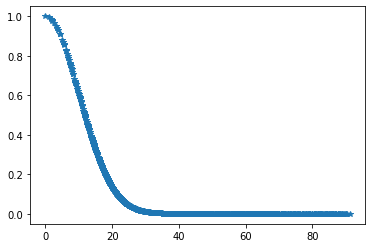

In [14]:
import matplotlib.pyplot as plt

plt.plot(model.stimulus.distance_matrix[-1],model.grid_rfs[-1],'*')

*Sanity check*

Verify that the cf profile has a value of 0 when the distance is infinite

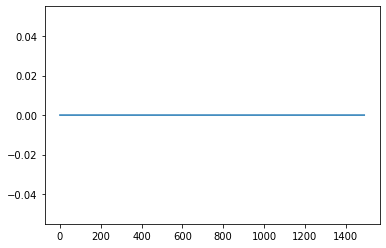

In [15]:
plt.plot(model.grid_rfs[-1][np.where(model.stimulus.distance_matrix[-1]==np.Inf)[0]])

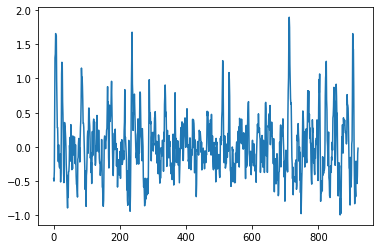

In [16]:
plt.plot(model.predictions[0])

Also generate model predictions.

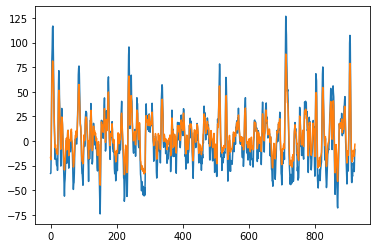

In [17]:
plt.plot(model.return_prediction(3,4,0,model.vert_centres_flat[0])[0])
plt.plot(model.return_prediction(5,1,5,model.vert_centres_flat[0])[0])

In [35]:
from prfpy.fit import CFFitter

gf = CFFitter(data=mydat,model=model, n_jobs=16)

In [26]:
gf.grid_fit(sigma_grid=sigmas,verbose=True)

Each batch contains approx. 119 voxels.


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   22.6s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  2.2min
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  5.2min
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  9.5min
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed: 12.3min finished


In [27]:
gf.gridsearch_params

array([[ 4.66680000e+04,  5.00000000e-01,  1.37192488e-01,
        -2.70249369e-03,  6.72359690e-02],
       [ 4.60810000e+04,  5.00000000e-01, -4.75821570e-02,
         4.08200826e-03,  3.90839837e-02],
       [ 4.32350000e+04,  5.00000000e-01,  2.35567942e-01,
        -3.82208638e-03,  1.58970356e-01],
       ...,
       [ 4.35750000e+04,  5.00000000e-01,  1.63006857e-01,
        -1.87919510e-03,  2.20300749e-01],
       [ 4.35750000e+04,  5.00000000e-01,  1.47202924e-01,
        -1.67482090e-03,  1.83755815e-01],
       [ 4.35750000e+04,  5.00000000e-01,  1.56788185e-01,
         6.55389624e-04,  2.06551597e-01]])

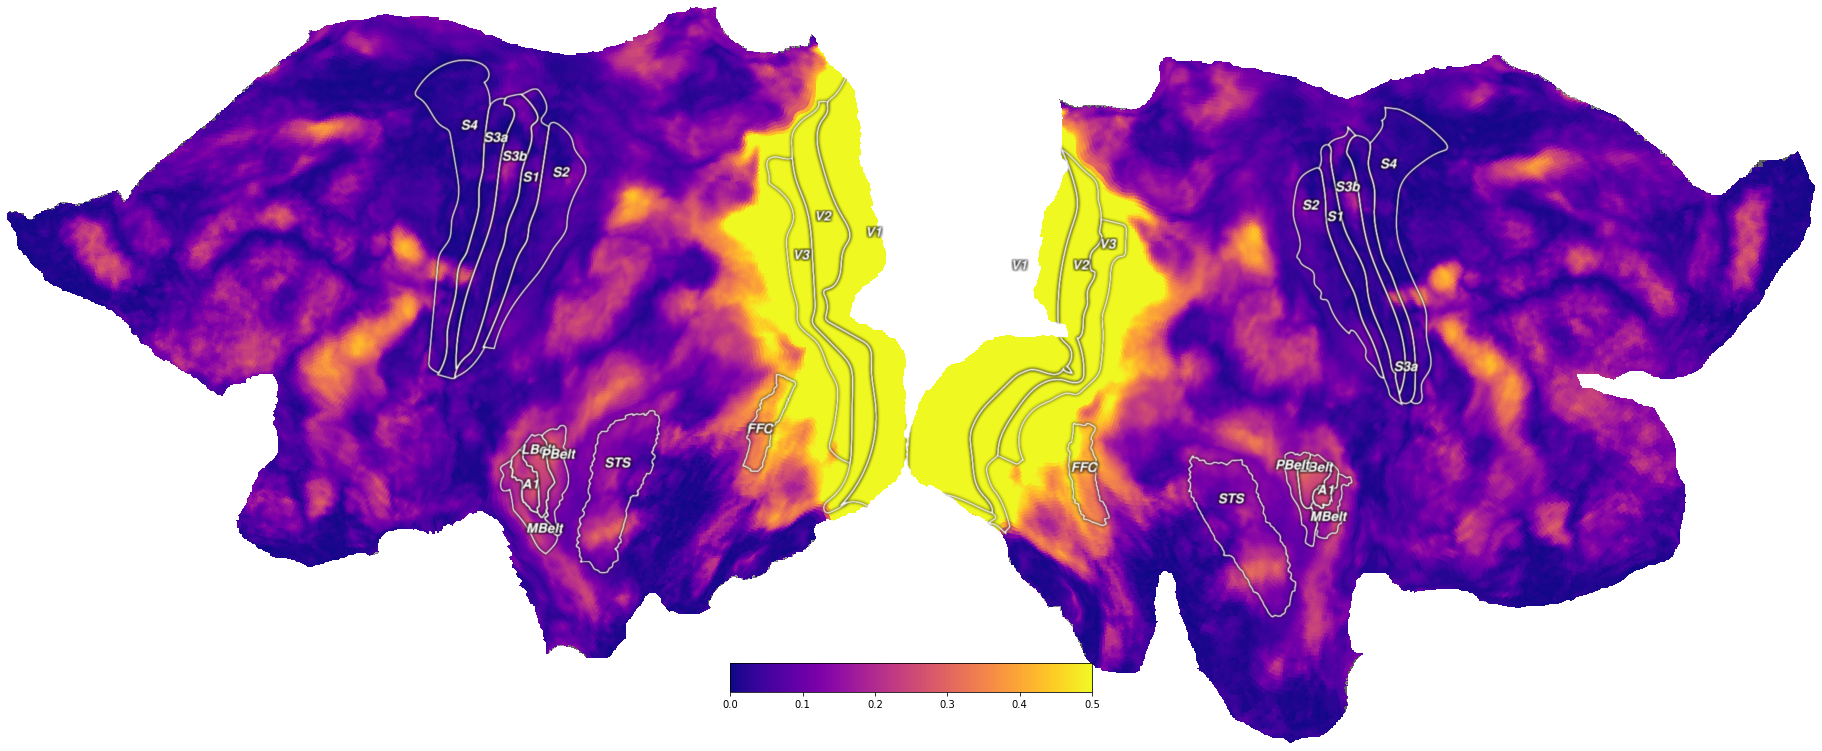

In [28]:
import cortex
from prfpy.utils import basic_plot

basic_plot(gf.gridsearch_params[:,-1],vmax=0.5,rois=True,cmap='plasma',colorbar=True,subject='hcp_999999')

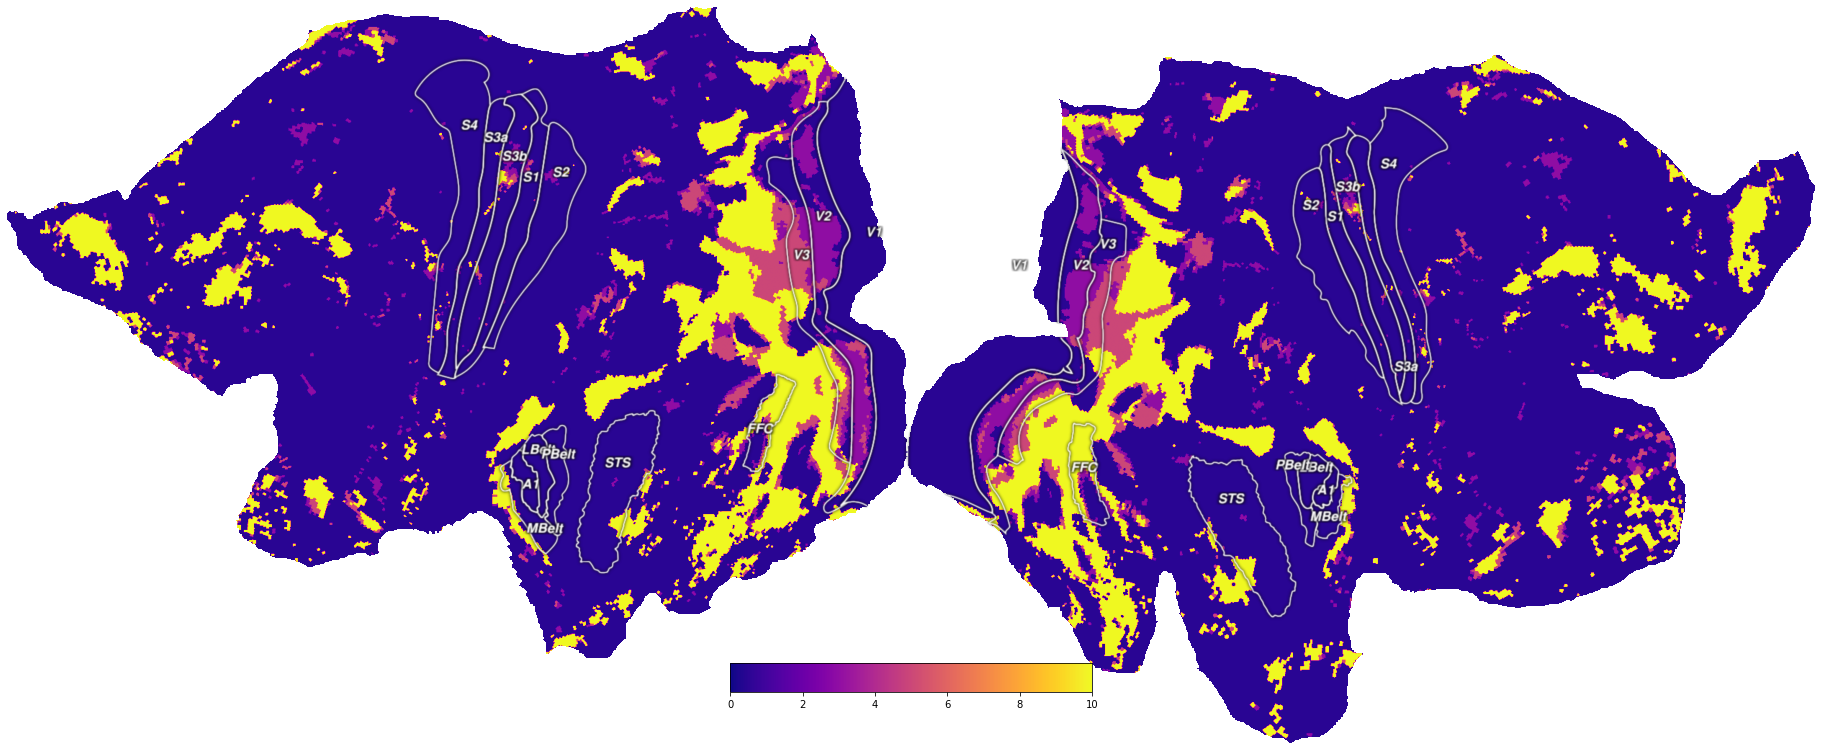

In [30]:
basic_plot(gf.gridsearch_params[:,1],vmax=10,rois=True,cmap='plasma',colorbar=True,subject='hcp_999999')

In [36]:
gf.quick_grid_fit(sigmas)

/tank/hedger/software/anaconda3/envs/p3/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


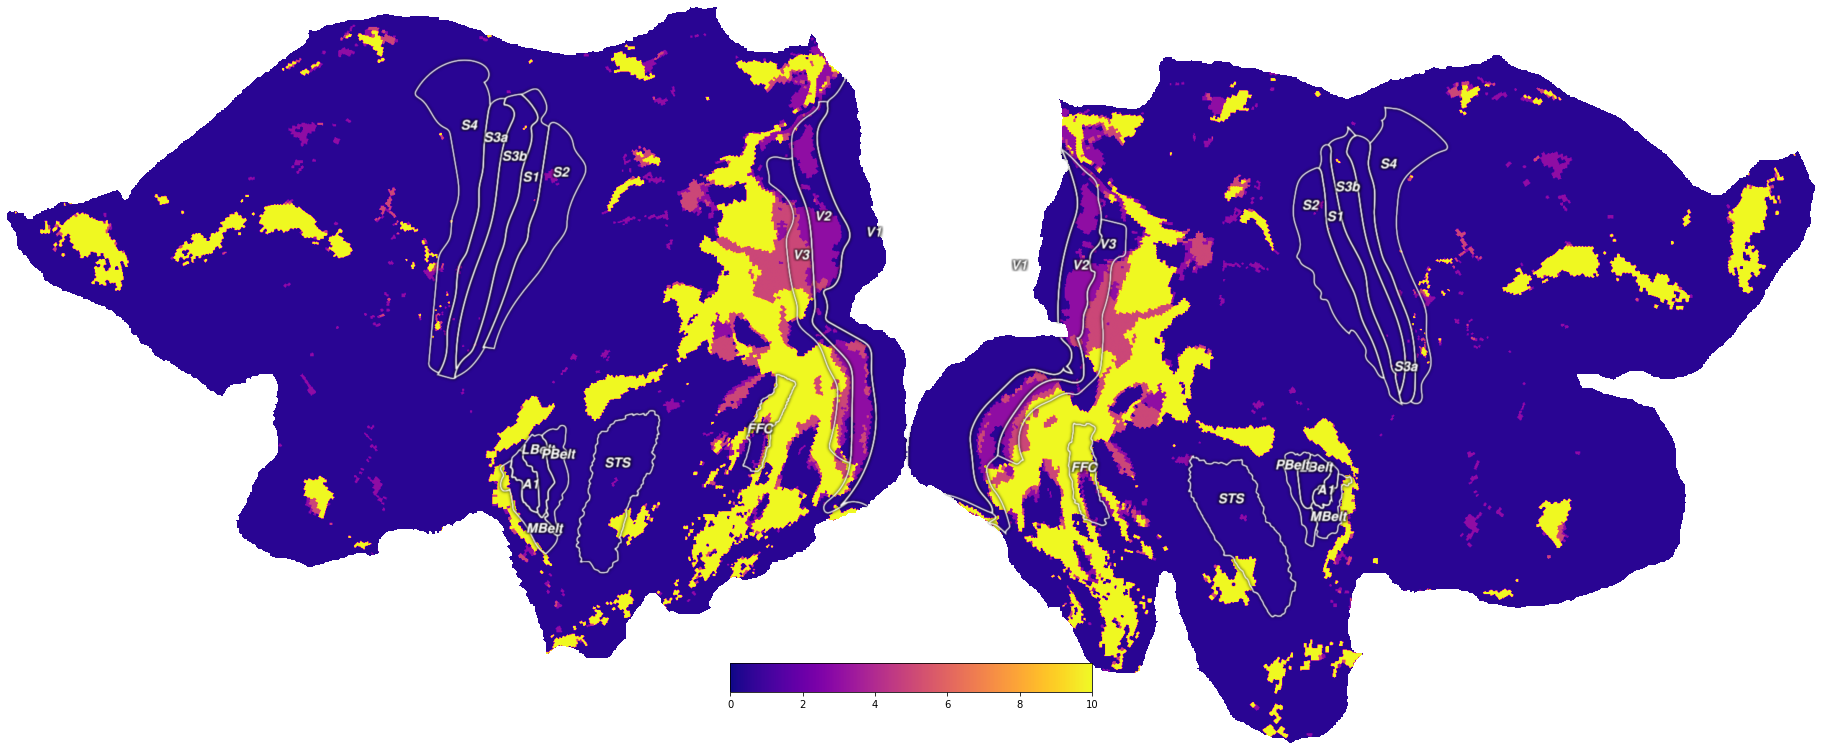

In [37]:
basic_plot(gf.quick_gridsearch_params[:,1],vmax=10,rois=True,cmap='plasma',colorbar=True,subject='hcp_999999')